In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.neighbors import NearestNeighbors
from scipy.stats import gaussian_kde, entropy

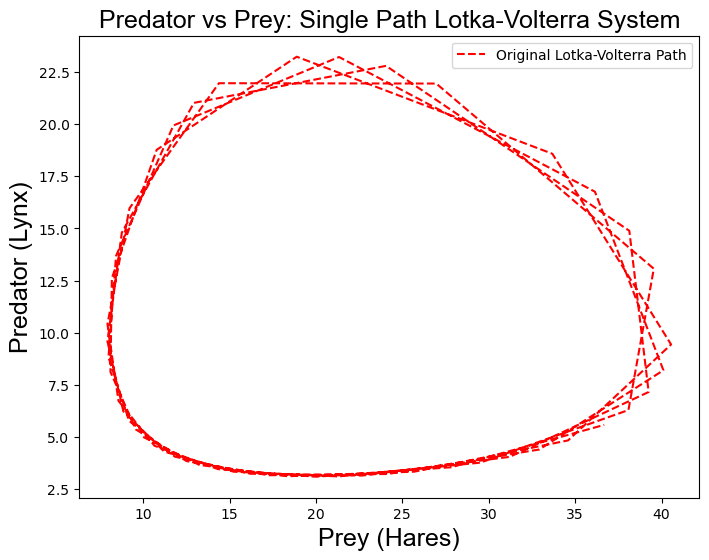

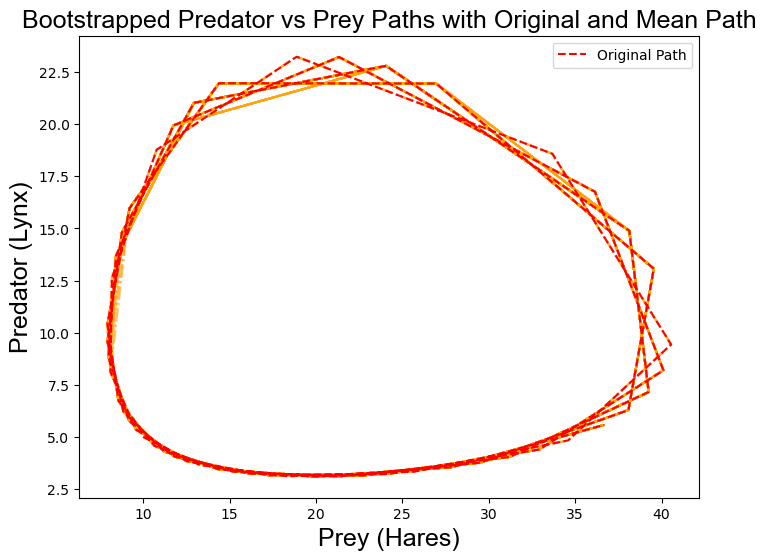

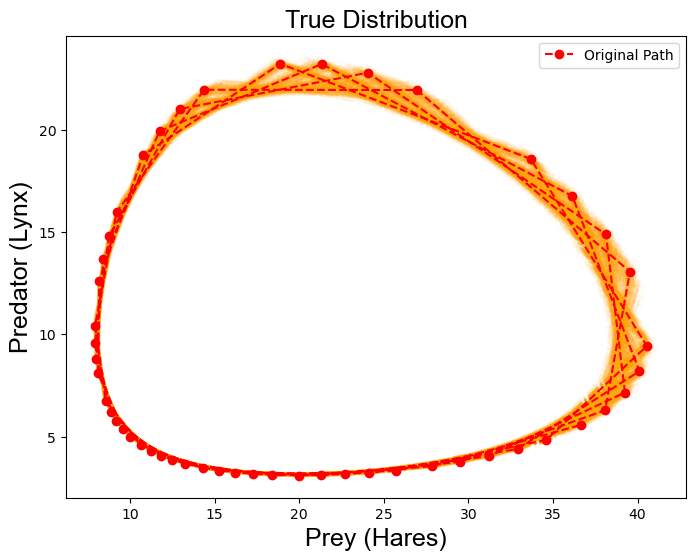

KL Divergence: 0.056708522442982814


In [3]:

# General parameters
num_points = 50
sigma_noise = 0.5

# Simulation Parameters
alpha = 1
beta = 0.1
delta = 0.075
gamma = 1.5

params = (alpha, beta, delta, gamma)

# Initial conditions
x0 = 10
y0 = 5
initial_state = [x0, y0]

# Time points
t = np.linspace(0, 24, num_points)

# Lotka-Volterra system function
def lotka_volterra_system(state, t, alpha, beta, delta, gamma):
    x, y = state
    dxdt = alpha*x - beta*x*y
    dydt = delta*x*y - gamma*y
    return [dxdt, dydt]

# Solve the ODE
solution = odeint(lotka_volterra_system, initial_state, t, args=params)
x, y = solution.T

# Step 1: Plot single path predator vs prey
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='Original Lotka-Volterra Path', color='red', linestyle = '--')
plt.xlabel('Prey (Hares)', fontsize=18, fontname='Arial')
plt.ylabel('Predator (Lynx)', fontsize=18, fontname='Arial')
plt.title('Predator vs Prey: Single Path Lotka-Volterra System', fontsize=18, fontname='Arial')
plt.legend()
plt.show()

# Matched Block Bootstrap Function
def matched_block_bootstrap_multivariate_optimized(time_series, block_size, num_bootstrap, 
                                                  matching_features=['mean', 'variance'], tolerance=0.5):
    n, m = time_series.shape
    num_blocks = n - block_size + 1

    # Create blocks and compute matching features
    blocks = []
    features = []
    for i in range(num_blocks):
        block = time_series[i:i+block_size]
        blocks.append(block)
        
        feature_vector = []
        for feature in matching_features:
            if feature == 'mean':
                feature_vector.extend(np.mean(block, axis=0))
            elif feature == 'variance':
                feature_vector.extend(np.var(block, axis=0))
        features.append(feature_vector)
    
    blocks = np.array(blocks)
    features = np.array(features)
    
    # Normalize features
    feature_means = np.mean(features, axis=0)
    feature_stds = np.std(features, axis=0) + 1e-8
    normalized_features = (features - feature_means) / feature_stds
    
    # Fit Nearest Neighbors model
    nbrs = NearestNeighbors(radius=tolerance, algorithm='ball_tree').fit(normalized_features)
    
    bootstrap_samples = np.zeros((num_bootstrap, n, m))

    for b in range(num_bootstrap):
        sample = []
        idx = 0
        while len(sample) < n:
            target_start = idx
            target_end = min(idx + block_size, n)
            target_block = time_series[target_start:target_end]
            
            if len(target_block) < block_size:
                pad_size = block_size - len(target_block)
                target_block = np.concatenate([target_block, time_series[:pad_size]], axis=0)
            
            target_feature = []
            for feature in matching_features:
                if feature == 'mean':
                    target_feature.extend(np.mean(target_block, axis=0))
                elif feature == 'variance':
                    target_feature.extend(np.var(target_block, axis=0))
            target_feature = np.array(target_feature)
            target_feature_normalized = (target_feature - feature_means) / feature_stds
            
            # Find neighbors within the radius
            indices = nbrs.radius_neighbors([target_feature_normalized], return_distance=False)[0]
            
            if len(indices) == 0:
                distances, indices = nbrs.kneighbors([target_feature_normalized], n_neighbors=1)
                selected_index = indices[0][0]
            else:
                selected_index = np.random.choice(indices)
            
            selected_block = blocks[selected_index]
            sample.extend(selected_block)
            idx += block_size
        
        bootstrap_samples[b] = np.array(sample[:n])
    
    return bootstrap_samples

# Step 2: Simulate a distribution of paths using Matched Block Bootstrap
time_series = np.column_stack((x, y))
block_size = 10
num_bootstrap = 200
num_true_samples = 200
bootstrap_samples = matched_block_bootstrap_multivariate_optimized(time_series, block_size, num_bootstrap)

# Plot the bootstrapped paths
plt.figure(figsize=(8, 6))
for i in range(num_bootstrap):
    plt.plot(bootstrap_samples[i, :, 0], bootstrap_samples[i, :, 1], color='orange', linestyle = '-.',alpha=0.05)
plt.plot(x, y, color='red', label='Original Path', linestyle='--')
# plt.plot(np.mean(bootstrap_samples[:, :, 0], axis=0), np.mean(bootstrap_samples[:, :, 1], axis=0), 
         # color='blue', label='Mean Bootstrap Path', linestyle='-.')
plt.xlabel('Prey (Hares)', fontsize=18, fontname='Arial')
plt.ylabel('Predator (Lynx)', fontsize=18, fontname='Arial')
plt.title('Bootstrapped Predator vs Prey Paths with Original and Mean Path', fontsize=18, fontname='Arial')
plt.legend()
plt.show()

# Step 3: Simulate Lotka-Volterra with parameters sampled from a distribution
mean_params = [1, 0.1, 0.075, 1.5]
std_params = np.array(mean_params) * 0.0025

# Sample new parameters
def gen_vary_params(mean_params, std_params, locs, num_sample):
    return np.random.normal(mean_params, std_params, (num_sample, len(mean_params)))

# Simulate paths using different parameters
param_dist = gen_vary_params(mean_params, std_params, locs=[1,1,1,1], num_sample=num_true_samples)
def simulate_params(params):
    alpha, beta, delta, gamma = params
    solution = odeint(lotka_volterra_system, initial_state, t, args=(alpha, beta, delta, gamma))
    return solution.T

path_dist = np.array([simulate_params(param) for param in param_dist])

# Plot paths with sampled parameters
plt.figure(figsize=(8, 6))
for i in range(num_true_samples):
    plt.plot(path_dist[i][0], path_dist[i][1], color='orange', linestyle = '-.', alpha=0.05)
plt.plot(x, y, 'r--o', label='Original Path')#, linestyle='--')
# plt.plot(np.mean(path_dist[:, 0], axis=0), np.mean(path_dist[:, 1], axis=0), 
#          color='blue', label='Mean Parameter Path', linewidth=2)
plt.xlabel('Prey (Hares)', fontsize=18, fontname='Arial')
plt.ylabel('Predator (Lynx)', fontsize=18, fontname='Arial')
plt.title('True Distribution', fontsize=18, fontname='Arial')
plt.legend()
plt.show()

# Step 4: Compute KL Divergence between two distributions
from scipy.stats import gaussian_kde, entropy
# Calculate KDEs for both bootstrapped and parametric distributions
def calculate_kde(values):
    kde = gaussian_kde(values.T)
    return kde

kde_bootstrap = calculate_kde(np.column_stack((bootstrap_samples[:, :, 0].ravel(), bootstrap_samples[:, :, 1].ravel())))
kde_parametric = calculate_kde(np.column_stack((path_dist[:, 0].ravel(), path_dist[:, 1].ravel())))

# Create a grid for KL divergence calculation
x_grid = np.linspace(np.min(x), np.max(x), num_points)
y_grid = np.linspace(np.min(y), np.max(y), num_points)
grid_points = np.column_stack([x_grid, y_grid])


# Calculate KL divergence
p = kde_bootstrap(grid_points.T)
q = kde_parametric(grid_points.T)

# Ensure p and q are normalized (sum to 1)
p /= p.sum()
q /= q.sum()


kl_divergence = entropy(p, q)

print(f"KL Divergence: {kl_divergence}")


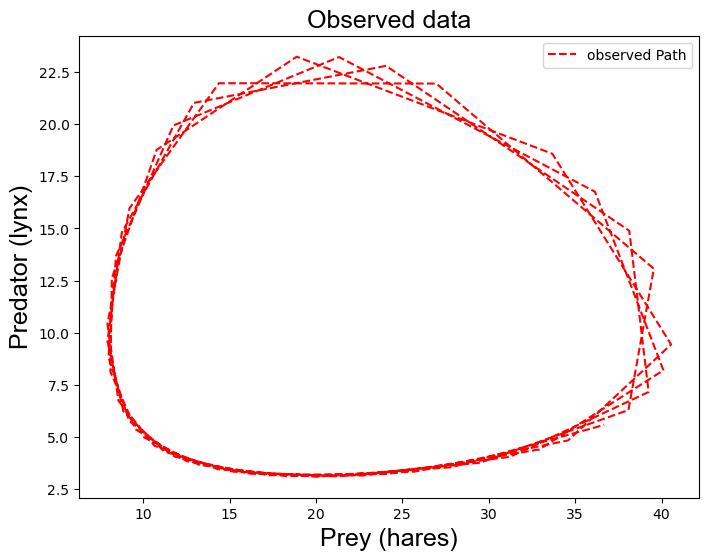

In [4]:
# Step 1: Plot single path predator vs prey
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='observed Path', color='red', linestyle = '--')
plt.xlabel('Prey (hares)', fontsize=18, fontname='Arial')
plt.ylabel('Predator (lynx)', fontsize=18, fontname='Arial')
plt.title('Observed data', fontsize=18, fontname='Arial')
plt.legend()
plt.show()

In [5]:
import numpy as np
from scipy.stats import gaussian_kde, ks_2samp

# Function to calculate KDE for a given sample
def calculate_kde(values):
    kde = gaussian_kde(values.T)
    return kde

# Flatten the bootstrapped and parametric samples to create 1D arrays for comparison
bootstrap_flattened = np.column_stack((bootstrap_samples[:, 0].ravel(), bootstrap_samples[:, 1].ravel())).ravel()
parametric_flattened = np.column_stack((path_dist[:, 0].ravel(), path_dist[:, 1].ravel())).ravel()

# Calculate the Kolmogorov-Smirnov distance between the two distributions
ks_statistic, p_value = ks_2samp(bootstrap_flattened, parametric_flattened)

# Output the KS statistic
print(f"Kolmogorov-Smirnov Statistic: {ks_statistic}")
print(f"P-value: {p_value}")


Kolmogorov-Smirnov Statistic: 0.35734999999999995
P-value: 2.1003921253045862e-88


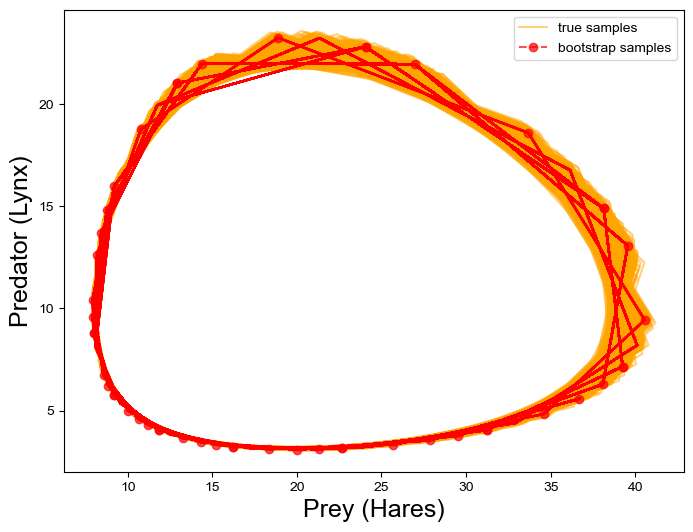

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
# Plot paths for both the distribution-generated paths and the matched block bootstrap paths
plt.figure(figsize=(8, 6))

# Plotting distribution-generated data paths in orange
for i in range(len(path_dist)):
    plt.plot(path_dist[i][0], path_dist[i][1], color='orange', alpha=0.5)
plt.plot(path_dist[i][0], path_dist[i][1], color='orange', alpha=0.5, label = 'true samples')
# Plotting matched block bootstrap paths in blue
for i in range(num_bootstrap):
    plt.plot(bootstrap_samples[i, :, 0], bootstrap_samples[i, :, 1], color='red', alpha=0.5)
plt.plot(bootstrap_samples[i, :, 0], bootstrap_samples[i, :, 1],'r--o', alpha=0.7, label = 'bootstrap samples')
# Labels and formatting
plt.xlabel('Prey (Hares)', fontsize=18, fontname='Arial')
plt.ylabel('Predator (Lynx)', fontsize=18, fontname='Arial')
# plt.title('True vs Bootstrap Distribution', fontsize=18, fontname='Arial')
plt.legend(fontsize=200, prop={'family': 'Arial'})
# Display the plot
plt.show()


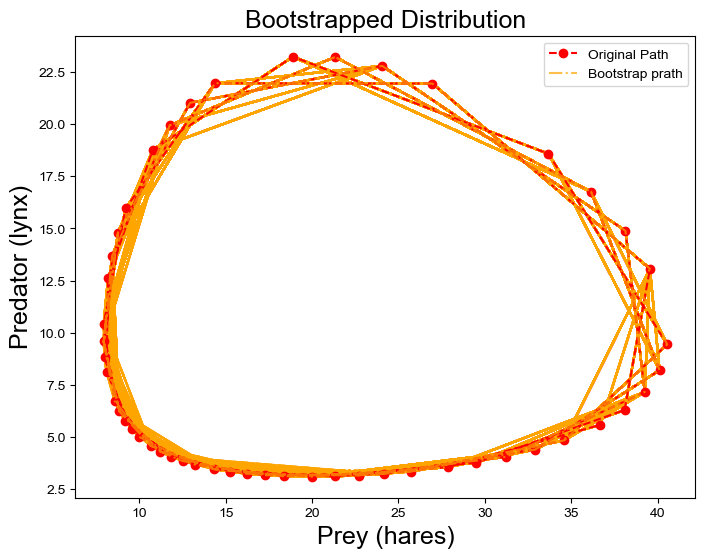

In [8]:
# Step 2: Simulate a distribution of paths using Matched Block Bootstrap
time_series = np.column_stack((x, y))
block_size = 3
num_bootstrap = 500
bootstrap_samples = matched_block_bootstrap_multivariate_optimized(time_series, block_size, num_bootstrap)

# Plot the bootstrapped paths
plt.figure(figsize=(8, 6))
for i in range(num_bootstrap):
    plt.plot(bootstrap_samples[i, :, 0], bootstrap_samples[i, :, 1], color='orange', linestyle = '-.',alpha=0.5)
plt.plot(x, y, 'r--o', label='Original Path')#, linestyle='--o')
plt.plot(bootstrap_samples[i, :, 0], bootstrap_samples[i, :, 1], color='orange', 
         linestyle = '-.',alpha=0.7, label = 'Bootstrap prath')
# plt.plot(np.mean(bootstrap_samples[:, :, 0], axis=0), np.mean(bootstrap_samples[:, :, 1], axis=0), 
         # color='blue', label='Mean Bootstrap Path', linestyle='-.')
plt.xlabel('Prey (hares)', fontsize=18, fontname='Arial')
plt.ylabel('Predator (lynx)', fontsize=18, fontname='Arial')
plt.title('Bootstrapped Distribution', fontsize=18, fontname='Arial')
plt.legend()
plt.show()

In [9]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Simulate paths using different parameters
def gen_vary_params(mean_params, std_params, locs, num_sample):
    return np.random.normal(mean_params, std_params, (num_sample, len(mean_params)))

# Define the lotka_volterra_system function if not already defined
def lotka_volterra_system(state, t, alpha, beta, delta, gamma):
    x, y = state
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Parameters
mean_params = [1.0, 0.1, 0.075, 1.5]
std_params = np.array(mean_params) * 0.1  # Assume 10% std deviation
num_bootstrap = 100
initial_state = [10, 5]  # Initial prey and predator populations
t = np.linspace(0, 24, 50)  # Time range for the simulation

# Generate varying parameters
param_dist = gen_vary_params(mean_params, std_params, locs=[1,1,1,1], num_sample=num_bootstrap)

# Function to simulate Lotka-Volterra system for each parameter set
def simulate_params(params):
    alpha, beta, delta, gamma = params
    solution = odeint(lotka_volterra_system, initial_state, t, args=(alpha, beta, delta, gamma))
    return solution.T  # Transpose to separate prey and predator values

# Simulate paths for the generated parameters
path_dist = np.array([simulate_params(param) for param in param_dist])

# Time points for plotting
time = np.linspace(0, 24, len(t))  # Ensure time matches the length of the solution



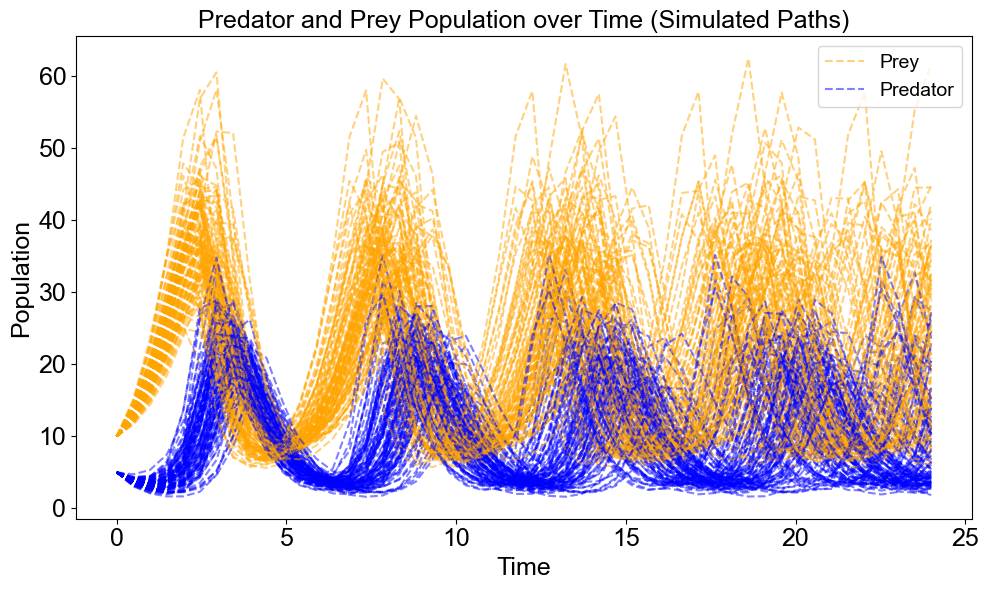

In [10]:
# Create the figure for plotting
plt.figure(figsize=(10, 6))

# Plot all the prey and predator paths from the parameter distribution
for i in range(len(path_dist)):
    prey = path_dist[i][0]  # Prey population
    predator = path_dist[i][1]  # Predator population
    plt.plot(time, prey, color = 'orange', alpha=0.5, label='Prey' if i == 0 else "", linestyle = '--')  # Plot prey paths
    plt.plot(time, predator, 'b--', alpha=0.5, label='Predator' if i == 0 else "")  # Plot predator paths

# Set labels, title, and font
plt.xlabel('Time', fontsize=18, fontname='Arial')
plt.ylabel('Population', fontsize=18, fontname='Arial')
plt.title('Predator and Prey Population over Time (Simulated Paths)', fontsize=18, fontname='Arial')

# Set tick labels font
plt.xticks(fontsize=18, fontname='Arial')
plt.yticks(fontsize=18, fontname='Arial')

# Add a legend (only show labels once)
plt.legend(fontsize=14)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
